# Intro

In this notebook i show my approach to the challenge SUA Outsmarting Outbreaks by Zindi. The goal of the challenge is to predict the number of patients with 7 diseases for the year 2023:

* Cholera
* Diarrhea
* Dysentery
* Intestinal Worms
* Malaria
* Schistosomiasis
* Typhoid

All this using historical data of the diseases from 2019 to 2023 and meteorological variables from nearby water sources, waste management and toilet instalations.

# Imports and Loading Datasets

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import cKDTree
from scipy.stats import kurtosis
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# Load datasets
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
toilets = pd.read_csv("toilets.csv")
waste_management = pd.read_csv("waste_management.csv")
water_sources = pd.read_csv("water_sources.csv")

# Data cleaning

To start I will clean up the data from duplicates and check the NAs distribution (if there are any). 

In [4]:
# Function to check for duplicates
def check_duplicates(name, df, check_column=None):
    if check_column and check_column in df.columns:  # Check ID column in train & test
        duplicate_count = df[df.duplicated(check_column, keep=False)].shape[0]
        print(f'Number of records with duplicated {check_column} in {name}: {duplicate_count}')
    else:  # Check full row duplicates in other datasets
        duplicate_count = df[df.duplicated(keep=False)].shape[0]
        print(f'Number of fully duplicated rows in {name}: {duplicate_count}')

# Apply function to datasets
check_duplicates("train", train, "ID")
check_duplicates("test", test, "ID")
check_duplicates("toilets", toilets)
check_duplicates("waste_management", waste_management)
check_duplicates("water_sources", water_sources)

Number of records with duplicated ID in train: 15189
Number of records with duplicated ID in test: 0
Number of fully duplicated rows in toilets: 0
Number of fully duplicated rows in waste_management: 120
Number of fully duplicated rows in water_sources: 0


In [5]:
# Show a few duplicates in train
duplicates_preview = train[train.duplicated('ID', keep=False)][['ID', 'Total']].head(10)
print(duplicates_preview)

                                                   ID  Total
2   ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0
3   ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0
4   ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0
6   ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    6.0
7   ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0
8   ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0
9   ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0
13  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_11_202...    0.0
14  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_11_202...    0.0
15  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_11_202...    0.0


So we have duplicates in waste_management that can be deleted and also there are duplicates in train. For the last ones, seemingly we have multiple reports for the same month for the same location, so I chose to take the sum of them as a new record.

Now let's also check the NAs for each dataframe

In [6]:
# Check for missing values in train and test datasets
missing_train = train.isna().sum()
missing_test = test.isna().sum()

# Display columns with missing values
print("Missing values in train dataset:")
print(missing_train[missing_train > 0])

print("\nMissing values in test dataset:")
print(missing_test[missing_test > 0])

Missing values in train dataset:
Total    1
dtype: int64

Missing values in test dataset:
Series([], dtype: int64)


In [7]:
# Find the row and column where NaN exists in the train dataset
nan_location = train[train.isna().any(axis=1)]

# Display the row(s) containing NaN
print(nan_location)

                                                      ID  Total  \
13319  ID_9a9f0ca2-bff2-4e4a-bb38-d9c83ef0602c_2_2019...    NaN   

                                      Location  \
13319  ID_9a9f0ca2-bff2-4e4a-bb38-d9c83ef0602c   

              Category_Health_Facility_UUID  Disease  Month  Year  \
13319  a9280aca-c872-46f5-ada7-4a7cc31cf6ec  Malaria      2  2019   

       Transformed_Latitude  Transformed_Longitude  
13319              -8.64597               68.26187  


Now that I know this i fill the NA with 0 and create a dataframe with:

* Max of Total
* Location
* Category_Health_Facility_UUID
* Disease
* Month
* Year
* Transformed_Latitude
* Transformed_Longitude

In [8]:
# Fill missing values in the 'Total' column
train['Total'] = train['Total'].fillna(0)

In [9]:
# Group by 'ID' and apply the appropriate aggregation for each column
aggregated_data = train.groupby('ID').agg({
    'Total': 'max',                             # Max of the 'Total' column
    'Location': 'first',                        # Keep the first value of 'Location'
    'Category_Health_Facility_UUID': 'first',   # Keep the first value of 'Category_Health_Facility_UUID'
    'Disease': 'first',                         # Keep the first value of 'Disease'
    'Month': 'first',                           # Keep the first value of 'Month'
    'Year': 'first',                            # Keep the first value of 'Year'
    'Transformed_Latitude': 'first',             # Keep the first value of 'Transformed_Latitude'
    'Transformed_Longitude': 'first'           # Keep the first value of 'Transformed_Longitude   
}).reset_index()

# Now, replace the original train dataframe with the aggregated data
train = aggregated_data

Now that I have this, there's another point to study, while there are duplicated per Location, Month, Year, Disease, there might also be records unavailable for some locations.

In [10]:
# Expected number of records per disease
print(f"Expected number of records per disease: {12 * 4 * train.Location.nunique()}\n")

# Print count of records per disease with formatting
for disease in train.Disease.unique():
    count = train[train['Disease'] == disease].shape[0]
    print(f"{disease}: {count}")

Expected number of records per disease: 2736

Diarrhea: 2167
Dysentery: 2143
Intestinal Worms: 2167
Malaria: 2167
Schistosomiasis: 2166
Typhoid: 2167
Cholera: 24


This means there are certain months with no information, for which we will assume there were no cases. Also, in particular for Cholera, all the records point to having 0 cases, reason why we will delete this Disease from train data and fill all the predictions in test with 0s.

In [11]:
train[train['Disease'] == 'Cholera']['Total'].value_counts()

Total
0.0    24
Name: count, dtype: int64

Now let's create the extended dataframe.

In [12]:
# Remove rows where Disease is 'Cholera'
train = train[train['Disease'] != 'Cholera']

# Reset the index
train.reset_index(drop=True, inplace=True)

# Generate all possible combinations of Location, Disease (excluding Cholera), Month, and Year
locations = train['Location'].unique()
diseases = [disease for disease in train['Disease'].unique() if disease != "Cholera"]  # Exclude Cholera
months = range(1, 13)  # Months 1 to 12
years = range(2019, 2023)  # Years from 2019 to 2022

# Generate all combinations
combinations = pd.MultiIndex.from_product([locations, diseases, years, months], 
                                          names=['Location', 'Disease', 'Year', 'Month']).to_frame(index=False)

# Merge with the original train data to find missing rows
train = pd.merge(combinations, train, on=['Location', 'Disease', 'Year', 'Month'], how='left')

# Fill missing Total values with 0
train['Total'] = train['Total'].fillna(0)

# First, create a temporary dataframe with the first non-NA values for each Location, Month, Year
fill_values = train.dropna(subset=['Category_Health_Facility_UUID', 'Transformed_Latitude', 'Transformed_Longitude']) \
    .groupby(['Location', 'Month', 'Year'])[['Category_Health_Facility_UUID', 'Transformed_Latitude', 'Transformed_Longitude']] \
    .first() \
    .reset_index()

# Now, create another dataframe to get the first non-NA values for each Location, ignoring Month and Year
location_fill_values = train.dropna(subset=['Category_Health_Facility_UUID', 'Transformed_Latitude', 'Transformed_Longitude']) \
    .groupby(['Location'])[['Category_Health_Facility_UUID', 'Transformed_Latitude', 'Transformed_Longitude']] \
    .first() \
    .reset_index()

# Merge both dataframes into the main dataframe
train = pd.merge(train, fill_values, on=['Location', 'Month', 'Year'], how='left', suffixes=('', '_filled'))
train = pd.merge(train, location_fill_values, on=['Location'], how='left', suffixes=('', '_location_filled'))

# Replace missing values with the filled values (prioritize Month-Year first, then Location)
train['Category_Health_Facility_UUID'] = train['Category_Health_Facility_UUID'].fillna(train['Category_Health_Facility_UUID_filled'])
train['Transformed_Latitude'] = train['Transformed_Latitude'].fillna(train['Transformed_Latitude_filled'])
train['Transformed_Longitude'] = train['Transformed_Longitude'].fillna(train['Transformed_Longitude_filled'])

# For remaining missing values, use the Location-level filled values
train['Category_Health_Facility_UUID'] = train['Category_Health_Facility_UUID'].fillna(train['Category_Health_Facility_UUID_location_filled'])
train['Transformed_Latitude'] = train['Transformed_Latitude'].fillna(train['Transformed_Latitude_location_filled'])
train['Transformed_Longitude'] = train['Transformed_Longitude'].fillna(train['Transformed_Longitude_location_filled'])

# Drop the temporary filled columns
train = train.drop(columns=['Category_Health_Facility_UUID_filled', 'Transformed_Latitude_filled', 'Transformed_Longitude_filled',
                            'Category_Health_Facility_UUID_location_filled', 'Transformed_Latitude_location_filled', 'Transformed_Longitude_location_filled'])

Now, there is also a slight mistake with the Category column of the hospital in the test dataset.

In [13]:
print('Number of categories in train dataset:')
print(train.Category_Health_Facility_UUID.nunique())
print('Number of categories in test dataset:')
print(test.Category_Health_Facility_UUID.nunique())

Number of categories in train dataset:
4
Number of categories in test dataset:
170


In [14]:
print('Categories in train dataset:')
print(train.Category_Health_Facility_UUID.unique())
print('Categories in test dataset:')
print(test.Category_Health_Facility_UUID.unique())

Categories in train dataset:
['a9280aca-c872-46f5-ada7-4a7cc31cf6ec'
 'a3761841-2a02-4c17-8589-d35aac4edc24'
 'b7f0a600-e19e-4c65-acb3-e28584dae35b'
 '56cd4cbb-23db-4dde-a6ae-9fc1ed7c8662']
Categories in test dataset:
['a9280aca-c872-46f5-ada7-4a7cc31cf6ec'
 'a3761841-2a02-4c17-8589-d35aac4edc24'
 'a3761841-2a02-4c17-8589-d35aac4edc25'
 'a3761841-2a02-4c17-8589-d35aac4edc26'
 'a3761841-2a02-4c17-8589-d35aac4edc27'
 'a3761841-2a02-4c17-8589-d35aac4edc28'
 'a3761841-2a02-4c17-8589-d35aac4edc29'
 'a3761841-2a02-4c17-8589-d35aac4edc30'
 'a3761841-2a02-4c17-8589-d35aac4edc31'
 'a3761841-2a02-4c17-8589-d35aac4edc32'
 'a3761841-2a02-4c17-8589-d35aac4edc33'
 'a3761841-2a02-4c17-8589-d35aac4edc34'
 'a3761841-2a02-4c17-8589-d35aac4edc35'
 'a3761841-2a02-4c17-8589-d35aac4edc36'
 'a3761841-2a02-4c17-8589-d35aac4edc37'
 'a3761841-2a02-4c17-8589-d35aac4edc38'
 'a3761841-2a02-4c17-8589-d35aac4edc39'
 'a3761841-2a02-4c17-8589-d35aac4edc40'
 'a3761841-2a02-4c17-8589-d35aac4edc41'
 'a3761841-2a02-4c17-8

The category seems to be indicated by the values before the first '_'.

In [15]:
# Keep only the part before the first underscore in 'Category_Health_Facility_UUID' column
train['Category_Health_Facility_UUID'] = train['Category_Health_Facility_UUID'].str.split('-').str[0]
test['Category_Health_Facility_UUID'] = test['Category_Health_Facility_UUID'].str.split('-').str[0]

Now let's delete the duplicated records in waste management and records with NA in water sources.

In [16]:
# Delete duplicates based on column 'Month_Year_lat_lon'
waste_management = waste_management.drop_duplicates(subset=['Month_Year_lat_lon'], keep='first')

In [17]:
# Drop unnecessary columns from supplementary datasets
for df in [toilets, waste_management, water_sources]:
    df.drop(columns=['Year', 'Month'], inplace=True)

In [18]:
# Rename columns for clarity
def rename_columns(df, prefix):
    for col in df.columns:
        if col not in ['Month_Year_lat_lon', 'lat_lon']:
            df.rename(columns={col: f"{prefix}_{col}"}, inplace=True)

rename_columns(toilets, "toilet")
rename_columns(waste_management, "waste")
rename_columns(water_sources, "water")

In [19]:
# Drop rows with missing latitude and longitude in water sources
water_sources.dropna(subset=['water_Transformed_Latitude'], inplace=True)

Creating aggregated datset for joint feature engineering.

In [20]:
# Add dataset column
train['dataset'] = 'train'
test['dataset'] = 'test'

# Combine train and test datasets for consistent preprocessing
hospital_data = pd.concat([train, test])

# Fill missing values in the 'Total' column
hospital_data['Total'] = hospital_data['Total'].fillna(0)

# EDA

There are X points of interest in this Exploratory Data Analysis:

* What's the distribution of the Total cases per Disease in train dataset?
* Is there any seasonality in each disease?
* Is there any autocorrelation on the Total cases per Disease in train dataset?
* Where are the hospital, waste, water and toilets located?
* Are there any "hotspots" for each Disease? (aka, if we can except the Location variable to have predictive power)

## Variables Distribution

To choose a model it's useful to check the distribution of the Total variable per Disease

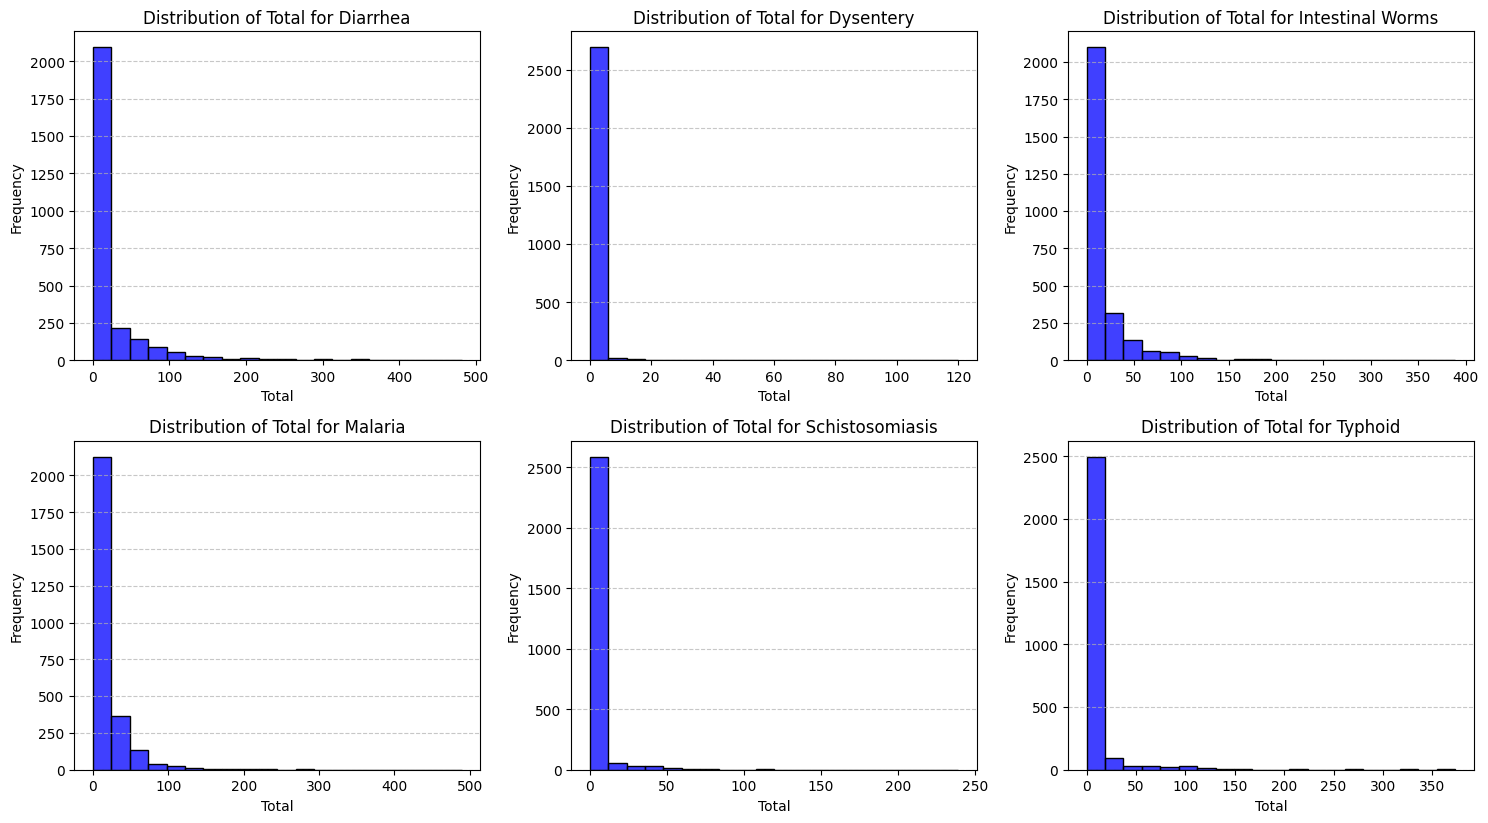

In [21]:
# Get unique diseases from the 'Disease' column
diseases = train['Disease'].unique()

# Define the number of rows and columns for the subplot grid
rows = 3
cols = 3
num_plots = len(diseases)  # Total number of unique diseases

# Create the figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))  # Adjust size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through diseases and create histograms
for i, disease in enumerate(diseases):
    if i >= rows * cols:  # Stop if we exceed the grid size
        break
    
    subset = train[train['Disease'] == disease]
    
    sns.histplot(subset['Total'], bins=20, kde=False, color='blue', ax=axes[i])
    
    # Set titles and labels
    axes[i].set_title(f'Distribution of Total for {disease}', fontsize=12)
    axes[i].set_xlabel('Total', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    
    # Add a grid
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

# Optimize layout
plt.tight_layout()
plt.show()

It looks like a logaritmic distribution.

## Seasonality per disease

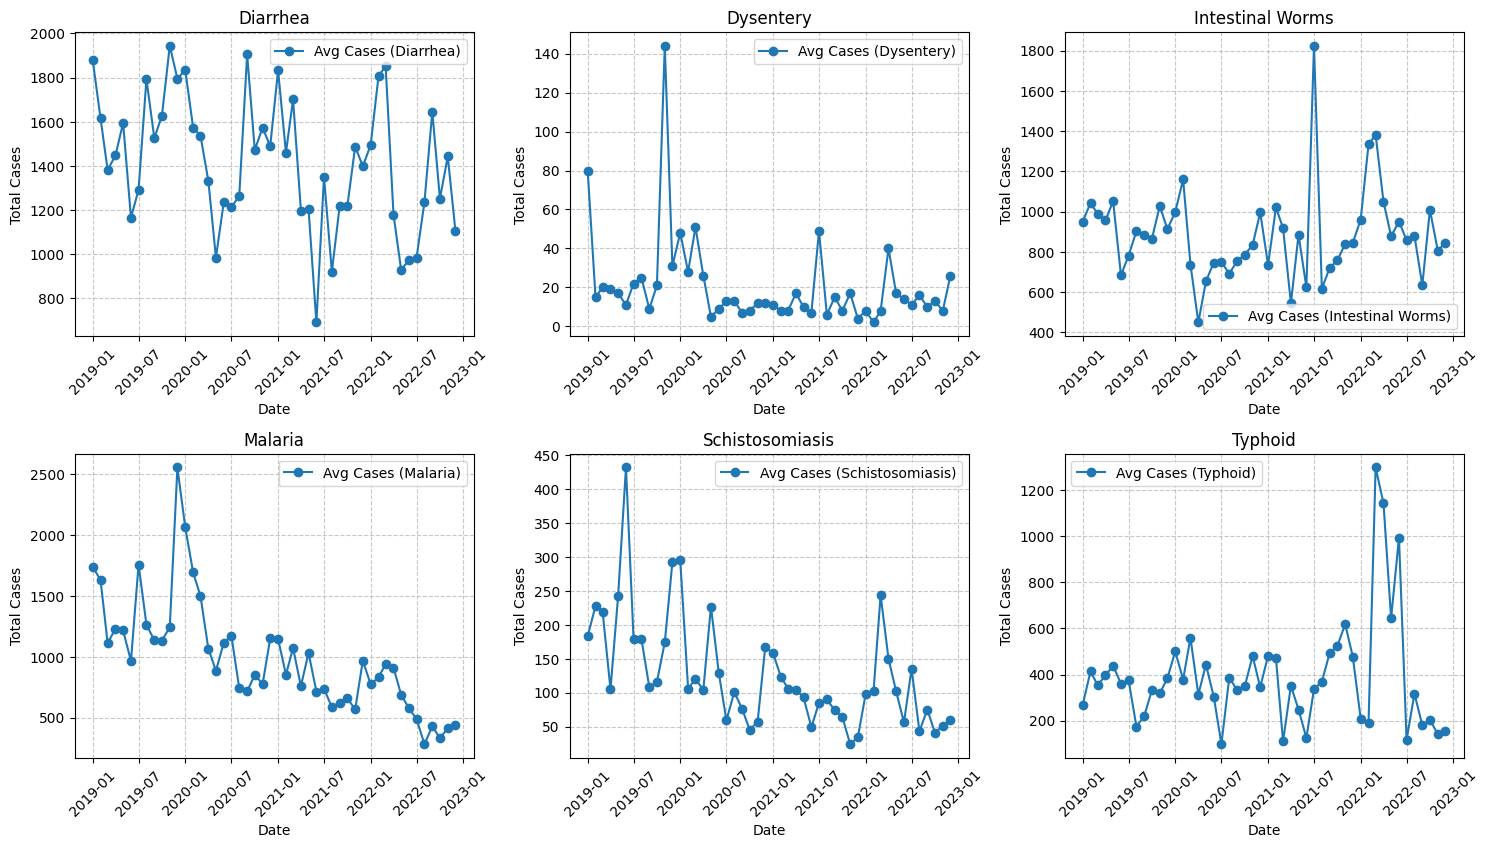

In [22]:
# Group by Disease, Year, and Month, then calculate the total cases
yearly_monthly_avg = train.groupby(['Disease', 'Year', 'Month'])['Total'].sum().reset_index()

# Get the list of unique diseases
unique_diseases = yearly_monthly_avg['Disease'].unique()

# Define the grid size
rows, cols = 3, 3
num_plots = len(unique_diseases)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()  # Flatten the 2D array for easier indexing

# Loop through each disease and plot
for i, disease in enumerate(unique_diseases):
    if i >= rows * cols:  # Stop if we exceed the grid size
        break
    
    # Filter the data for the current disease
    disease_data = yearly_monthly_avg[yearly_monthly_avg['Disease'] == disease].copy()
    
    # Create a Date column combining Year and Month
    disease_data['Date'] = pd.to_datetime(disease_data[['Year', 'Month']].assign(Day=1))
    
    # Plot on the respective subplot
    axes[i].plot(disease_data['Date'], disease_data['Total'], marker='o', label=f'Avg Cases ({disease})')
    
    # Set titles and labels
    axes[i].set_title(f'{disease}', fontsize=12)
    axes[i].set_xlabel('Date', fontsize=10)
    axes[i].set_ylabel('Total Cases', fontsize=10)
    
    # Improve readability
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

# Optimize layout
plt.tight_layout()
plt.show()

There seems to be at least some peaks in similar months in each disease. But there is not a heavily marked seasonality in any of them.

## Autocorrelation

c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_bas

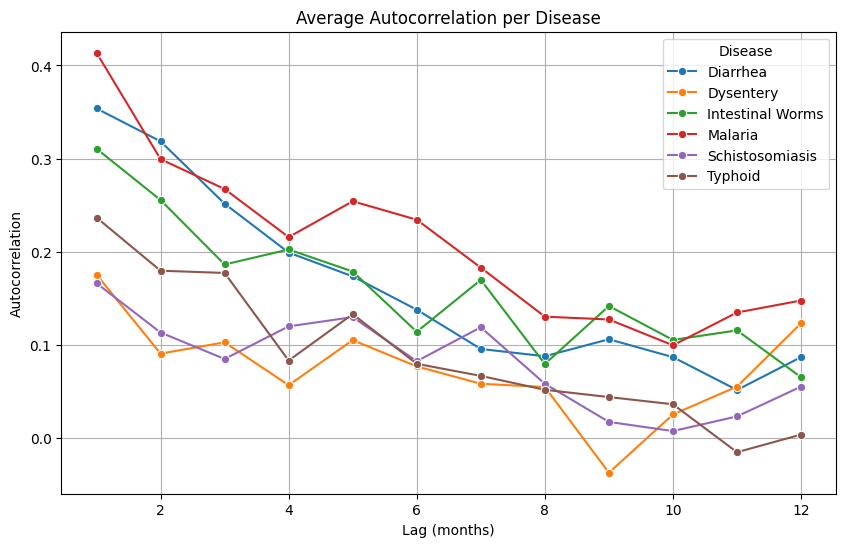

In [23]:
def compute_autocorrelation(df):
    results = []
    
    for disease, df_disease in df.groupby("Disease"):
        valid_locations = df_disease.groupby("Location")["Total"].transform(lambda x: x.sum() > 0)
        df_filtered = df_disease[valid_locations]
        
        autocorrs = {lag: [] for lag in range(1, 13)}
        
        for location, df_location in df_filtered.groupby("Location"):
            ts = df_location.sort_values(["Year", "Month"])['Total']
            for lag in range(1, 13):
                autocorrs[lag].append(ts.autocorr(lag=lag))
                
        avg_autocorr = {lag: np.nanmean(autocorrs[lag]) for lag in range(1, 13)}
        
        for lag, value in avg_autocorr.items():
            results.append({"Disease": disease, "Lag": lag, "Autocorrelation": value})
    
    return pd.DataFrame(results)

# Calculate autocorrelation
autocorr_df = compute_autocorrelation(train)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=autocorr_df, x="Lag", y="Autocorrelation", hue="Disease", marker="o")
plt.title("Average Autocorrelation per Disease")
plt.xlabel("Lag (months)")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

Autocorrelations don't seem to go above 0.5 at all. Hence, they will not be used as features for the modelling section.

## Trend per disease

In [24]:
# Group by Disease and Year, then sum the Total cases
yearly_totals = train.groupby(['Disease', 'Year'])['Total'].sum().reset_index()

# Pivot the table so that years become columns
summary_table = yearly_totals.pivot(index='Disease', columns='Year', values='Total')

# Ensure all years (2019-2022) are present in columns
summary_table = summary_table.reindex(columns=[2019, 2020, 2021, 2022], fill_value=0)

# Print the table
print(summary_table)

Year                 2019     2020     2021     2022
Disease                                             
Diarrhea          19066.0  17420.0  15685.0  15906.0
Dysentery           414.0    232.0    160.0    173.0
Intestinal Worms  11049.0   9556.0  10332.0  11589.0
Malaria           16970.0  13720.0   9711.0   7098.0
Schistosomiasis    2457.0   1486.0   1004.0   1156.0
Typhoid            4035.0   4487.0   4606.0   5587.0


The trend in the diseases is not that noticiable, and actually seem to spike in certain years. Thus, I won't use coefficients to adjust predictions to trends.

## Hospital locations

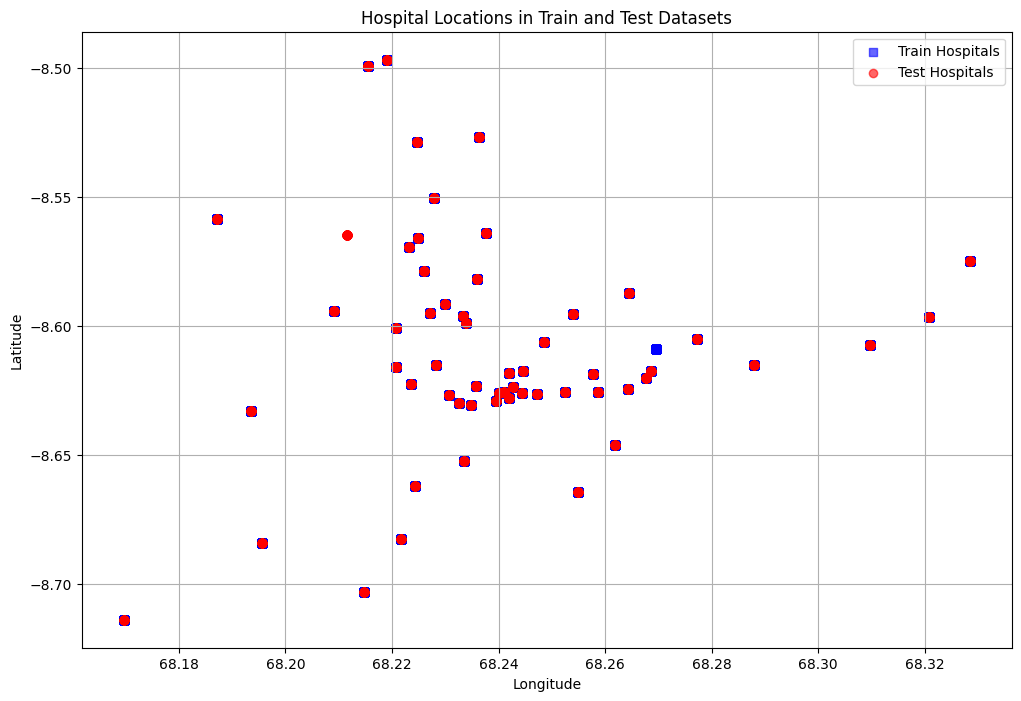

In [25]:
def plot_hospital_locations(train, test):
    plt.figure(figsize=(12, 8))

    # Plot hospital locations from the train dataset
    plt.scatter(train['Transformed_Longitude'], train['Transformed_Latitude'], label='Train Hospitals', alpha=0.6, marker='s', color='blue')

    # Plot hospital locations from the test dataset
    plt.scatter(test['Transformed_Longitude'], test['Transformed_Latitude'], label='Test Hospitals', alpha=0.6, marker='o', color='red')

    # Add title and labels
    plt.title('Hospital Locations in Train and Test Datasets')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Show legend and grid
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()

plot_hospital_locations(train, test)

There seems to be one location that is only in train and not in test.

In [26]:
# Visualize locations for a specific year and month
# Note the months/year should in the given timeframe [2019, 2023]
def plot_locations(year=2022, month=1, month_name='January'):
    if year < 2019 or year > 2023:
        print("Invalid year. Please choose a year between 2019 and 2023.")
        return

    if month < 1 or month > 12:
        print("Invalid month. Please choose a month between 1 and 12.")
        return

    if month_name.capitalize() not in ['January', 'February', 'March',
                                       'April', 'May', 'June', 'July',
                                       'August', 'September', 'October',
                                       'November', 'December']:
        print("Invalid month name. Please choose from 'January' to 'December'.")
        return

    plt.figure(figsize=(12, 8))
    subsets = [
        (hospital_data.query(f"Year == {year} and Month == {month}"), 'Transformed', 'Hospital', 's'),
        (water_sources.query(f"water_Month_Year == '{month}_{year}'"), 'water_Transformed', 'Water', 'o'),
        (waste_management.query(f"waste_Month_Year == '{month}_{year}'"), 'waste_Transformed', 'Waste', 'x'),
        (toilets.query(f"toilet_Month_Year == '{month}_{year}'"), 'toilet_Transformed', 'Toilet', '^'),
    ]
    for df, prefix, label, marker in subsets:
        plt.scatter(df[f'{prefix}_Longitude'], df[f'{prefix}_Latitude'], label=label, alpha=0.6, marker=marker)
    plt.title(f'Locations ({month_name.capitalize()} {year})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Invert the Y-axis
    plt.gca().invert_yaxis()

    plt.legend()
    plt.grid(True)
    plt.show()

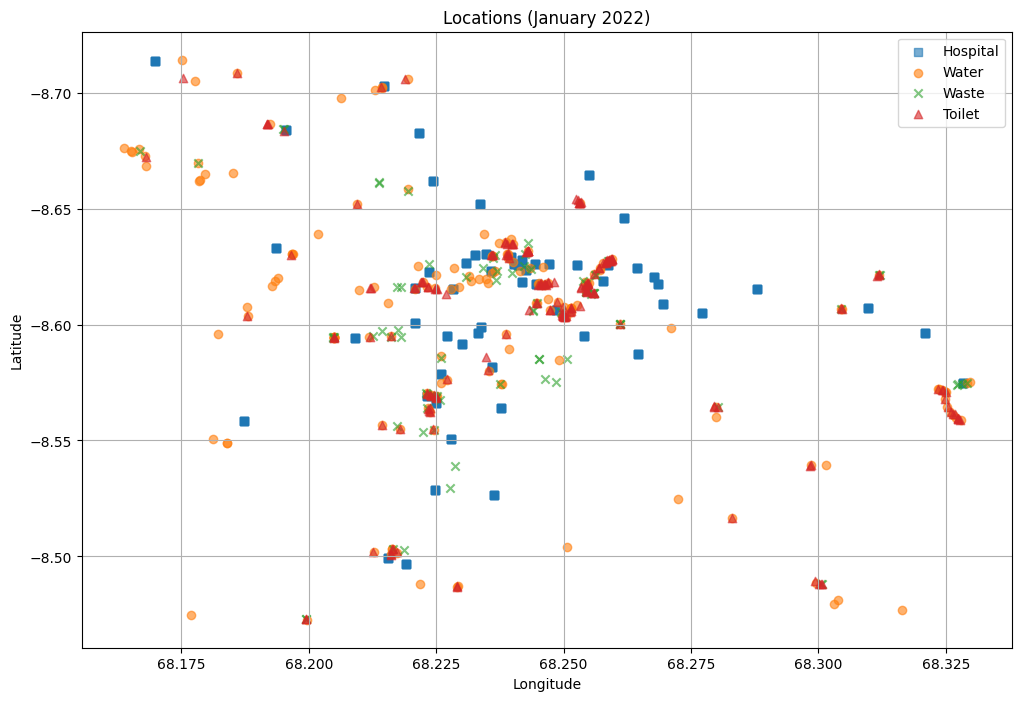

In [27]:
plot_locations()

Certain hospitals are further away from each other and from toilets, waste and water, while others seem to be in some kind of city. Also, I checked and the locations are the same per month, so this plot is valid for all months and years.

## Hotspots per Disease

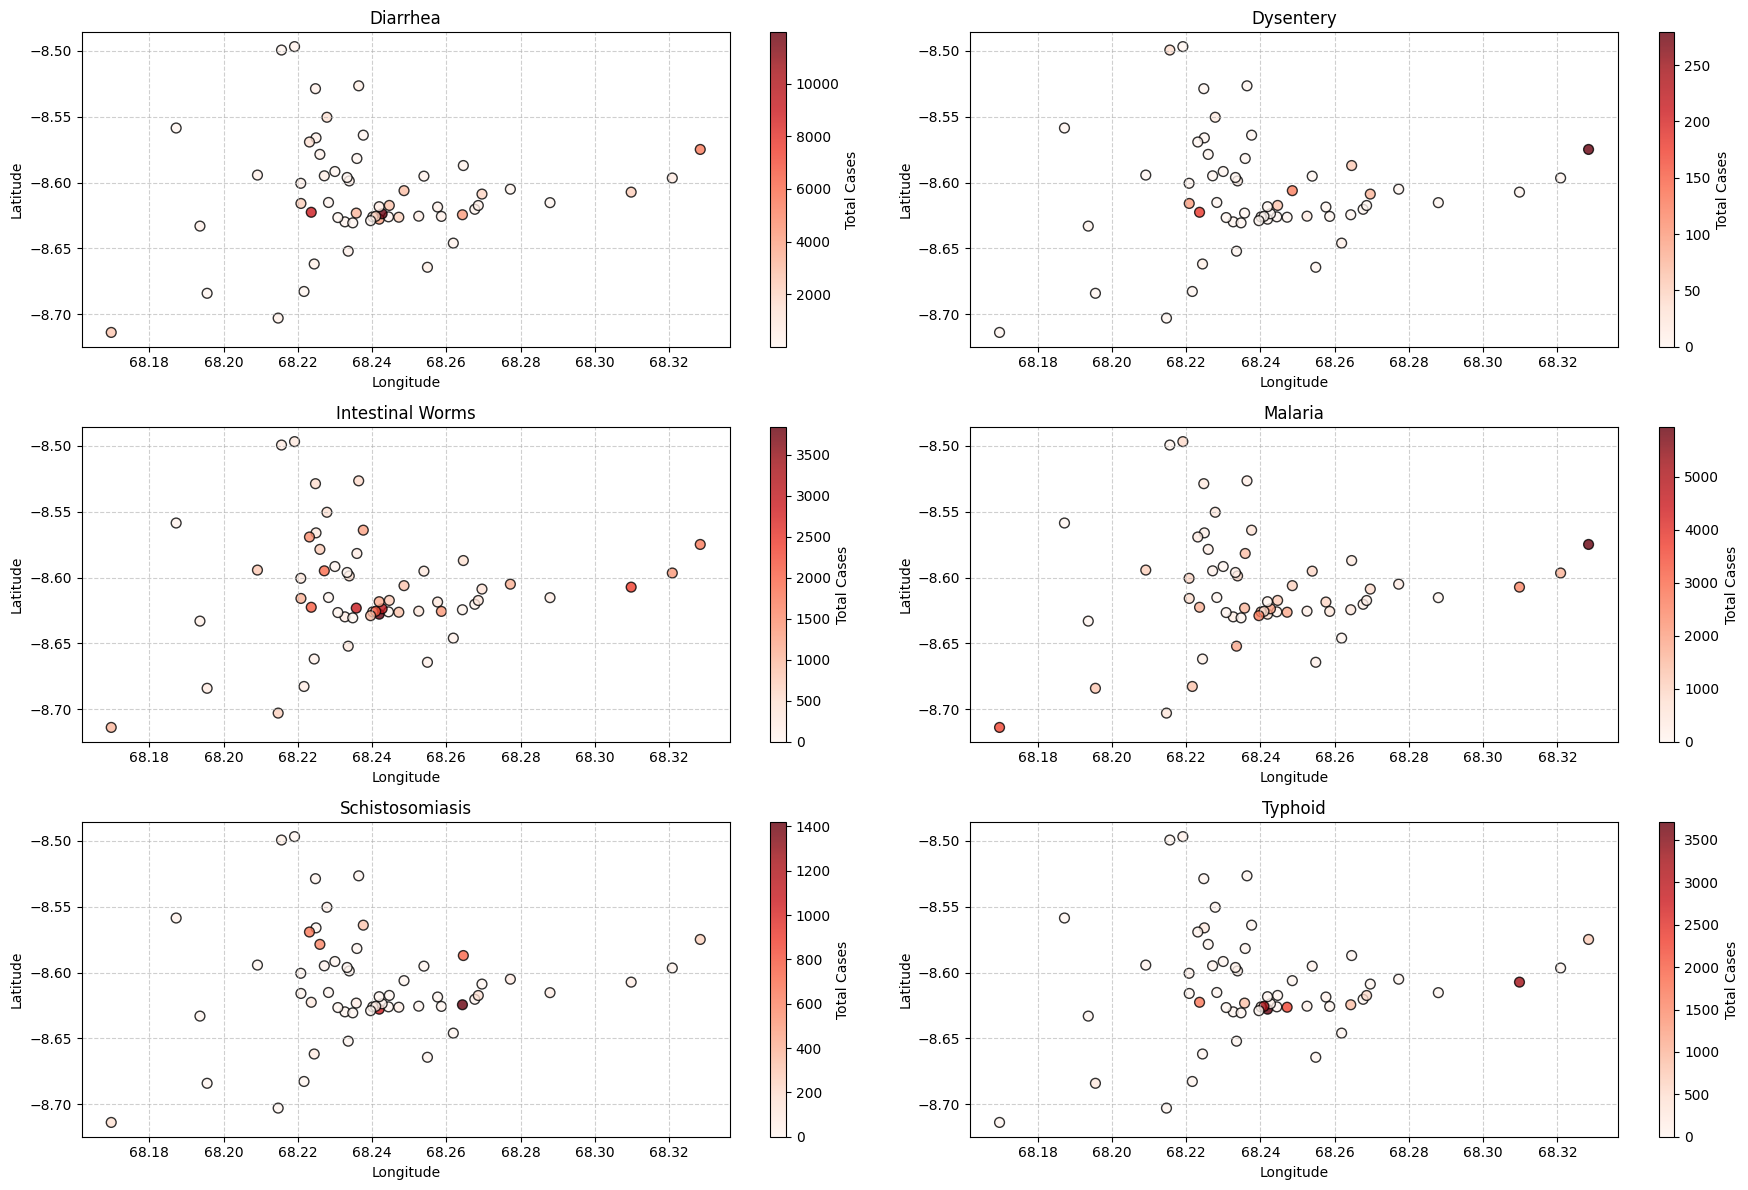

In [28]:
# Group by Location and Disease, summing the Total column
grouped_data = train.groupby(['Location', 'Disease']).agg({
    'Total': 'sum',
    'Transformed_Longitude': 'first',  # Keep the geographic columns
    'Transformed_Latitude': 'first'
}).reset_index()

# Rename columns for clarity
grouped_data.rename(columns={
    'Transformed_Longitude': 'Longitude',
    'Transformed_Latitude': 'Latitude'
}, inplace=True)

# Get unique diseases
unique_diseases = grouped_data['Disease'].unique()

# Define grid size
rows = 3
cols = int(np.ceil(len(unique_diseases) / rows))  # Adjust columns dynamically

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()  # Flatten to easily iterate

# Loop through diseases and create heatmaps
for i, disease in enumerate(unique_diseases):
    # Filter data for the current disease
    disease_data = grouped_data[grouped_data['Disease'] == disease]
    
    # Plot on respective subplot
    scatter = axes[i].scatter(
        x=disease_data['Longitude'],
        y=disease_data['Latitude'],
        c=disease_data['Total'],  # Color corresponds to Total cases
        s=50,
        cmap='Reds',
        alpha=0.8,
        edgecolor='k'
    )
    
    # Add title and labels
    axes[i].set_title(f'{disease}', fontsize=12)
    axes[i].set_xlabel('Longitude', fontsize=10)
    axes[i].set_ylabel('Latitude', fontsize=10)
    axes[i].grid(True, linestyle='--', alpha=0.6)
    
    # Add colorbar
    cbar = fig.colorbar(scatter, ax=axes[i])
    cbar.set_label('Total Cases')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Optimize layout
plt.tight_layout()
plt.show()

It doesn't seem to be as many hotspots as I would expect. There are cases in which two close hospitals have a high number of cases, but that can be caused by the meteorological variables too.

# Feature Engineering

For the featuring engineering I already had in mind to use boosting models for prediction. Because of that I decided not to use PCA to reduce the features. The features that have been added are:

* Meteorological variables from the closest toilet, water source and waste management in each Month Year.
* Number of toilets, water sources and waste management installaton in a certain radius.
* Kurtosis, min, max, mean and std per Disease, per Location on the previous Year.
* 1 and 2 month lags on the meteorological variables previously calculated.
* Ratio between each current meteorological variable and the 1 lag meteorological variable.
* Ratio between each 1 lag meteorological variable and 2 month meteorological variable.

Also the month is included as a feature for the models.

## Features using nearest neighbours

For this features I'll add to each Location the meteorological variables from the nearest toilet, water source and waste management as features. Also, the number of toilets, water sources and waste management in a certain radius is added as a feature to each Location.

In [29]:
def find_nearest(hospital_df, location_df, lat_col, lon_col, id_col):
    # Create a cKDTree for efficient nearest neighbour search
    tree = cKDTree(location_df[[lat_col, lon_col]].values)
    nearest = {}
    # Loop through each hospital and find the nearest site in location_df
    for _, row in hospital_df.iterrows():
        _, idx = tree.query([row['Transformed_Latitude'], row['Transformed_Longitude']])
        nearest[row['ID']] = location_df.iloc[idx][id_col]
    return nearest

In [30]:
# Create hospital_unique dataframe with unique Location and their transformed lat lon
hospital_unique = hospital_data[['Location', 'Transformed_Latitude', 'Transformed_Longitude']].drop_duplicates()

# Create unique dataframes for toilets, water, and waste by taking the first record for each lat_lon
toilets_unique = toilets[['lat_lon', 'toilet_Transformed_Latitude', 'toilet_Transformed_Longitude']].drop_duplicates()
water_unique = water_sources[['lat_lon', 'water_Transformed_Latitude', 'water_Transformed_Longitude']].drop_duplicates()
waste_unique = waste_management[['lat_lon', 'waste_Transformed_Latitude', 'waste_Transformed_Longitude']].drop_duplicates()

# Rename the columns to match the format in hospital_data
toilets_unique.rename(columns={'toilet_Transformed_Latitude': 'Transformed_Latitude', 
                               'toilet_Transformed_Longitude': 'Transformed_Longitude'}, inplace=True)

water_unique.rename(columns={'water_Transformed_Latitude': 'Transformed_Latitude', 
                             'water_Transformed_Longitude': 'Transformed_Longitude'}, inplace=True)

waste_unique.rename(columns={'waste_Transformed_Latitude': 'Transformed_Latitude', 
                             'waste_Transformed_Longitude': 'Transformed_Longitude'}, inplace=True)

In [31]:
def count_neighbors_and_closest_distance(hospital_df, location_df, lat_col, lon_col, id_col, radius=0.0125, neighbor_type='Neighbor'):
    # Create a cKDTree for efficient nearest neighbor search
    tree = cKDTree(location_df[[lat_col, lon_col]].values)
    
    neighbors_count = []
    closest_distances = []
    
    # Loop through each hospital and count neighbors & find the closest distance
    for _, row in hospital_df.iterrows():
        # Find all points within the given radius
        neighbors_idx = tree.query_ball_point([row['Transformed_Latitude'], row['Transformed_Longitude']], radius)
        neighbors_count.append(len(neighbors_idx))  # Count neighbors
        
        # Find the closest distance to any neighbor
        if len(location_df) > 0:
            closest_distance, _ = tree.query([row['Transformed_Latitude'], row['Transformed_Longitude']], k=1)
        else:
            closest_distance = np.nan  # If no neighbors, return NaN
        
        closest_distances.append(closest_distance)
    
    # Add new columns for neighbor count and closest distance
    hospital_df[f'{neighbor_type}_in_radius'] = neighbors_count
    hospital_df[f'closest_d_{neighbor_type}'] = closest_distances
    
    return hospital_df

# Count neighbors and calculate closest distances for each category
hospital_unique = count_neighbors_and_closest_distance(hospital_unique, toilets_unique, 
                                                       'Transformed_Latitude', 'Transformed_Longitude', 
                                                       id_col='lat_lon', neighbor_type='toilet')

hospital_unique = count_neighbors_and_closest_distance(hospital_unique, water_unique, 
                                                       'Transformed_Latitude', 'Transformed_Longitude', 
                                                       id_col='lat_lon', neighbor_type='water')

hospital_unique = count_neighbors_and_closest_distance(hospital_unique, waste_unique, 
                                                       'Transformed_Latitude', 'Transformed_Longitude', 
                                                       id_col='lat_lon', neighbor_type='waste')

In [32]:
hospital_unique.head()

,Location,Transformed_Latitude,Transformed_Longitude,toilet_in_radius,closest_d_toilet,water_in_radius,closest_d_water,waste_in_radius,closest_d_waste
0,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,-8.52657,68.23638,0,0.030642,0,0.026623,1,0.009098
288,ID_02b8390e-f332-4ed5-9e24-9163f09ba478,-8.55043,68.22782,3,0.005536,3,0.005354,4,0.005362
576,ID_02f25962-4419-4e72-9402-3f6c513ec454,-8.62780,68.24192,30,0.002846,26,0.002112,10,0.002454
864,ID_030ee103-7194-452c-b0e6-58142de19bf6,-8.58172,68.23590,3,0.001634,7,0.001730,5,0.007546
1152,ID_069981aa-3e3d-4008-8460-0b9a564b93ce,-8.61525,68.28792,0,0.018492,0,0.018604,0,0.018572


In [33]:
# Ensure unique identifier columns exist in all supplementary datasets
for df, prefix in [(toilets, 'toilet'), (waste_management, 'waste'), (water_sources, 'water')]:
    df[f"{prefix}_Month_Year_lat_lon"] = (
        df[f"{prefix}_Month_Year"] + '_' +
        df[f"{prefix}_Transformed_Latitude"].astype(str) + '_' +
        df[f"{prefix}_Transformed_Longitude"].astype(str)
    )

In [34]:
# Merge datasets with nearest locations
merged_data = hospital_data.copy()
datasets = [
    (toilets, 'toilet', 'toilet_Month_Year_lat_lon'),
    (waste_management, 'waste', 'waste_Month_Year_lat_lon'),
    (water_sources, 'water', 'water_Month_Year_lat_lon'),
]

In [35]:
for df, prefix, id_col in datasets:
    nearest = find_nearest(merged_data, df, f"{prefix}_Transformed_Latitude", f"{prefix}_Transformed_Longitude", id_col)
    nearest_df = pd.DataFrame(list(nearest.items()), columns=['ID', id_col])
    merged_data = merged_data.merge(nearest_df, on="ID").merge(df, on=id_col)

In [36]:
merged_data = merged_data.merge(hospital_unique[['Location', 'toilet_in_radius', 'water_in_radius', 'waste_in_radius']], on='Location', how='left')

## Statistics per Disease - Location

In [37]:
# Filter the data for Year < 2023 to calculate statistics for previous years
data_till_2022 = merged_data[merged_data['Year'] < 2023]

# Define a function to calculate aggregation statistics (min, max, median, std)
def calculate_stats(data, column_name, calculate_kurtosis=False):
    # Aggregations with column-specific suffix
    agg_stats = data.groupby(['Location', 'Disease', 'Year'])[column_name].agg(
        **{
            f'min_{column_name}': 'min',
            f'max_{column_name}': 'max',
            f'mean_{column_name}': 'mean',
            f'median_{column_name}': 'median',
            f'std_{column_name}': 'std',
        }
    ).reset_index()

    if calculate_kurtosis:
        # Calculate kurtosis if applicable
        kurt_stats = data.groupby(['Location', 'Disease', 'Year']).apply(
            lambda group: pd.Series({f'kurtosis_{column_name}': kurtosis(group[column_name], fisher=True, nan_policy='omit')})
        ).reset_index()

        # Merge kurtosis with other stats
        agg_stats = pd.merge(agg_stats, kurt_stats, on=['Location', 'Disease', 'Year'], how='left')

    return agg_stats

# Calculate statistics for each relevant column
stats_total = calculate_stats(data_till_2022, 'Total', calculate_kurtosis=True)
stats_toilet_tp = calculate_stats(data_till_2022, 'toilet_tp')  
stats_water_tp = calculate_stats(data_till_2022, 'water_tp')   
stats_waste_tp = calculate_stats(data_till_2022, 'waste_tp')    
stats_toilet_2d = calculate_stats(data_till_2022, 'toilet_2d')  
stats_water_2d = calculate_stats(data_till_2022, 'water_2d')   
stats_waste_2d = calculate_stats(data_till_2022, 'waste_2d') 

# Increment the Year to match statistics with the next year's data
for stats in [stats_total, stats_toilet_tp, stats_water_tp, stats_waste_tp, stats_toilet_2d, stats_water_2d, stats_waste_2d]:
    stats['Year'] += 1

# Merge all statistics back into the original data
merged_data = pd.merge(merged_data, stats_total, on=['Location', 'Disease', 'Year'], how='left')
merged_data = pd.merge(merged_data, stats_toilet_tp, on=['Location', 'Disease', 'Year'], how='left')
merged_data = pd.merge(merged_data, stats_water_tp, on=['Location', 'Disease', 'Year'], how='left')
merged_data = pd.merge(merged_data, stats_waste_tp, on=['Location', 'Disease', 'Year'], how='left')
merged_data = pd.merge(merged_data, stats_toilet_2d, on=['Location', 'Disease', 'Year'], how='left')
merged_data = pd.merge(merged_data, stats_water_2d, on=['Location', 'Disease', 'Year'], how='left')
merged_data = pd.merge(merged_data, stats_waste_2d, on=['Location', 'Disease', 'Year'], how='left')

C:\Users\ifake\AppData\Local\Temp\ipykernel_10832\348769639.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  kurt_stats = data.groupby(['Location', 'Disease', 'Year']).apply(


## Lags, Ratios and Anomalies

**Meteorological columns**  

In [38]:
# Filter for useful columns
columns_to_lag = ['toilet_10u', 'toilet_10v', 'toilet_2d', 'toilet_2t', 'toilet_evabs', 'toilet_evaow', 'toilet_evatc', 'toilet_evavt', 
'toilet_albedo', 'toilet_lshf', 'toilet_lai_hv', 'toilet_lai_lv', 'toilet_pev', 'toilet_ro', 'toilet_src', 'toilet_skt', 'toilet_es', 
'toilet_stl1', 'toilet_stl2', 'toilet_stl3', 'toilet_stl4', 'toilet_ssro', 'toilet_slhf', 'toilet_ssr', 'toilet_str', 'toilet_sp', 'toilet_sro', 
'toilet_sshf', 'toilet_ssrd', 'toilet_strd', 'toilet_e', 'toilet_tp', 'toilet_swvl1', 'toilet_swvl2', 'toilet_swvl3', 'toilet_swvl4', 'waste_10u', 
'waste_10v', 'waste_2d', 'waste_2t', 'waste_evabs', 'waste_evaow', 'waste_evatc', 'waste_evavt', 'waste_albedo', 'waste_lshf', 'waste_lai_hv', 
'waste_lai_lv', 'waste_pev', 'waste_ro', 'waste_src', 'waste_skt', 'waste_es', 'waste_stl1', 'waste_stl2', 'waste_stl3', 'waste_stl4', 
'waste_ssro', 'waste_slhf', 'waste_ssr', 'waste_str', 'waste_sp', 'waste_sro', 'waste_sshf', 'waste_ssrd', 'waste_strd', 'waste_e', 'waste_tp', 
'waste_swvl1', 'waste_swvl2', 'waste_swvl3', 'waste_swvl4', 'water_10u', 'water_10v', 'water_2d', 'water_2t', 'water_evabs', 'water_evaow', 
'water_evatc', 'water_evavt', 'water_albedo', 'water_lshf', 'water_lai_hv', 'water_lai_lv', 'water_pev', 'water_ro', 'water_src', 'water_skt', 
'water_es', 'water_stl1', 'water_stl2', 'water_stl3', 'water_stl4', 'water_ssro', 'water_slhf', 'water_ssr', 'water_str', 'water_sp', 'water_sro', 
'water_sshf', 'water_ssrd', 'water_strd', 'water_e', 'water_tp', 'water_swvl1', 'water_swvl2', 'water_swvl3', 'water_swvl4']

# Sort the data by Location, Year, and Month
merged_data = merged_data.sort_values(by=['Location', 'Year', 'Month'])

# Compute the median values for 2019 grouped by Location
median_values_2019 = merged_data[merged_data['Year'] == 2019].groupby('Location')[columns_to_lag].median()

# Merge the computed median values back into the original DataFrame
merged_data = merged_data.merge(median_values_2019, on='Location', suffixes=('', '_2019_median'), how='left')

# List to store DataFrames with lagged values
lagged_dfs = []

# Generate lagged features efficiently
for lag in range(1, 3):  # Creating lags 1 and 2
    lagged_df = merged_data.groupby(['Location', 'Disease'])[columns_to_lag].shift(lag)
    lagged_df.columns = [f'{col}_lag{lag}' for col in columns_to_lag]  # Rename columns to reflect lagged values
    lagged_dfs.append(lagged_df)

# Concatenate all lagged DataFrames together
lagged_data = pd.concat(lagged_dfs, axis=1)

# Fill NaN values in lagged columns using the 2019 median values
for lag in range(1, 3):
    for col in columns_to_lag:
        lagged_data[f'{col}_lag{lag}'] = lagged_data[f'{col}_lag{lag}'].fillna(merged_data[f'{col}_2019_median'])

# Merge the lagged data back into the original DataFrame
merged_data = pd.concat([merged_data, lagged_data], axis=1)

# Drop temporary median columns used for filling missing values
merged_data = merged_data.drop(columns=[f'{col}_2019_median' for col in columns_to_lag])

# Optimize memory usage
merged_data = merged_data.copy()

In [39]:
# Create a dictionary to store the new ratio columns
ratio_columns = {}

# Compute the ratios and store them in the dictionary
for col in columns_to_lag:
    ratio_columns[f'{col}_ratio1'] = (merged_data[col] - merged_data[f'{col}_lag1']) / merged_data[f'{col}_lag1']
    ratio_columns[f'{col}_ratio2'] = (merged_data[f'{col}_lag1'] - merged_data[f'{col}_lag2']) / merged_data[f'{col}_lag2']

# Convert the dictionary into a DataFrame
ratio_df = pd.DataFrame(ratio_columns)

# Concatenate all new columns at once to avoid fragmentation issues
merged_data = pd.concat([merged_data, ratio_df], axis=1)

# Replace infinities and NaN values if needed
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data.fillna(0, inplace=True)

# Modeling

In [40]:
# Converting 'object' type columns to 'category'
for col in merged_data.select_dtypes(include='object').columns:
    merged_data[col] = merged_data[col].astype('category')

In [41]:
# Separate the data back into train and test based on the 'dataset' column
train_df = merged_data[(merged_data['dataset'] == 'train')]
test_df = merged_data[merged_data['dataset'] == 'test']

In [42]:
# List of columns to exclude
columns_to_exclude = [
    'Total', 'Year', 'ID', 'water_Transformed_Latitude', 'water_Transformed_Longitude', 'water_Month_Year', 'lat_lon', 
    'Month_Year_lat_lon', 'dataset', 'toilet_Month_Year_lat_lon', 'toilet_Transformed_Latitude', 
    'toilet_Transformed_Longitude', 'toilet_Month_Year', 'lat_lon_x', 'Month_Year_lat_lon_x', 
    'waste_Month_Year_lat_lon', 'waste_Transformed_Latitude', 'waste_Transformed_Longitude', 
    'waste_Month_Year', 'lat_lon_y', 'Month_Year_lat_lon_y', 'water_Month_Year_lat_lon'
]

# Create the filtered list of columns
m1 = [col for col in train_df.columns if col not in columns_to_exclude]

## Per Disease Cross Validation

To cross validate the model I'll use data from 2019 and 2020 to predict 2021 and then data from 2020 and 2021 to predict 2022. The objective metric for hyperparameter optimization will be the average MAE of those two periods. Also, note that I train one model per Disease and choose each Disease best hyperparameters.

**2021 and 2022 cross validation**

In [43]:
def objective(trial, train_df, m1, disease):
    """Objective function for Optuna hyperparameter tuning."""
    
    # Filter Disease
    disease_df = train_df[train_df["Disease"] == disease].copy()

    # Data for predicting 2021
    train_2021 = disease_df[disease_df["Year"].isin([2019, 2020])]
    test_2021 = disease_df[disease_df["Year"] == 2021]

    # Data for predicting 2022
    train_2022 = disease_df[disease_df["Year"].isin([2020, 2021])]
    test_2022 = disease_df[disease_df["Year"] == 2022]

    if test_2021.empty or test_2022.empty:
        return np.inf

    # Define features and target
    X_train_2021, y_train_2021 = train_2021[m1], train_2021["Total"]
    X_test_2021, y_test_2021 = test_2021[m1], test_2021["Total"]

    X_train_2022, y_train_2022 = train_2022[m1], train_2022["Total"]
    X_test_2022, y_test_2022 = test_2022[m1], test_2022["Total"]

    # Definir hyperparams
    params = {
        "objective": "regression",
        "metric": "mae",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
    }

    # 10-fold CV
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    mae_scores_2021 = []
    mae_scores_2022 = []

    # Train and predict for 2021
    for train_index, valid_index in kf.split(X_train_2021):
        X_train_fold, X_valid_fold = X_train_2021.iloc[train_index], X_train_2021.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train_2021.iloc[train_index], y_train_2021.iloc[valid_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)],
                  eval_metric="mae")

        y_pred_2021 = model.predict(X_test_2021)
        mae_scores_2021.append(mean_absolute_error(y_test_2021, y_pred_2021))

    # Train and predict for 2022
    for train_index, valid_index in kf.split(X_train_2022):
        X_train_fold, X_valid_fold = X_train_2022.iloc[train_index], X_train_2022.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train_2022.iloc[train_index], y_train_2022.iloc[valid_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)],
                  eval_metric="mae")

        y_pred_2022 = model.predict(X_test_2022)
        mae_scores_2022.append(mean_absolute_error(y_test_2022, y_pred_2022))

    # Mean MAE of both years
    avg_mae_2021 = np.mean(mae_scores_2021)
    avg_mae_2022 = np.mean(mae_scores_2022)
    
    final_mae = (avg_mae_2021 + avg_mae_2022) / 2
    return final_mae

def train_lgbm_with_optuna(train_df, m1, disease, n_trials=50):
    
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, train_df, m1, disease), n_trials=n_trials)

    print(f"Best MAE: {study.best_value}")
    print(f"Best Hyperparams: {study.best_params}")

    return study.best_value, study.best_params

In [44]:
results = {}

for disease in train_df["Disease"].unique():
    print(f"Training model for Disease: {disease} 🦠")
    best_mae, best_params = train_lgbm_with_optuna(train_df, m1, disease, n_trials=25)
    
    # Store results in a dictionary
    results[disease] = {
        "Best MAE": best_mae,
        "Best Parameters": best_params
    }
    
    print("-" * 50)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df

[I 2025-03-02 20:14:40,334] A new study created in memory with name: no-name-5dda3bff-938b-4001-8961-d60190d26e8d


Training model for Disease: Diarrhea 🦠


[I 2025-03-02 20:14:44,446] Trial 0 finished with value: 15.988466029847704 and parameters: {'max_depth': 7, 'num_leaves': 53, 'learning_rate': 0.01629418370434368, 'feature_fraction': 0.5933026802436447, 'bagging_fraction': 0.9637874248531071, 'bagging_freq': 2, 'lambda_l1': 4.813878104086962, 'lambda_l2': 7.703983624850545}. Best is trial 0 with value: 15.988466029847704.
[I 2025-03-02 20:14:48,331] Trial 1 finished with value: 16.141167872158327 and parameters: {'max_depth': 10, 'num_leaves': 59, 'learning_rate': 0.044086849887946894, 'feature_fraction': 0.5343639586156921, 'bagging_fraction': 0.9108060085247551, 'bagging_freq': 3, 'lambda_l1': 9.262448997130816, 'lambda_l2': 5.225285939118799}. Best is trial 0 with value: 15.988466029847704.
[I 2025-03-02 20:14:51,152] Trial 2 finished with value: 16.135480313817553 and parameters: {'max_depth': 3, 'num_leaves': 90, 'learning_rate': 0.060599667864400054, 'feature_fraction': 0.8932303755070866, 'bagging_fraction': 0.8920019413960061

Best MAE: 15.52307104804614
Best Hyperparams: {'max_depth': 11, 'num_leaves': 127, 'learning_rate': 0.023303355422130773, 'feature_fraction': 0.9045180289035437, 'bagging_fraction': 0.8503108560333733, 'bagging_freq': 6, 'lambda_l1': 4.757554282512022, 'lambda_l2': 8.479272437953366}
--------------------------------------------------
Training model for Disease: Dysentery 🦠


[I 2025-03-02 20:16:05,393] Trial 0 finished with value: 0.6458220238809488 and parameters: {'max_depth': 3, 'num_leaves': 89, 'learning_rate': 0.1500237376943373, 'feature_fraction': 0.7101889808315296, 'bagging_fraction': 0.7912831853924254, 'bagging_freq': 7, 'lambda_l1': 1.756645622477766, 'lambda_l2': 4.003918611712544}. Best is trial 0 with value: 0.6458220238809488.
[I 2025-03-02 20:16:07,907] Trial 1 finished with value: 0.6220363955073799 and parameters: {'max_depth': 3, 'num_leaves': 125, 'learning_rate': 0.15007023657451574, 'feature_fraction': 0.823726017407829, 'bagging_fraction': 0.9261897956573104, 'bagging_freq': 3, 'lambda_l1': 3.233523935124676, 'lambda_l2': 5.537994509671091}. Best is trial 1 with value: 0.6220363955073799.
[I 2025-03-02 20:16:10,321] Trial 2 finished with value: 0.5626295453390997 and parameters: {'max_depth': 6, 'num_leaves': 82, 'learning_rate': 0.05248932548883185, 'feature_fraction': 0.6971545976445288, 'bagging_fraction': 0.5265037933512358, 'b

Best MAE: 0.4828225975927828
Best Hyperparams: {'max_depth': 10, 'num_leaves': 130, 'learning_rate': 0.027097426976528213, 'feature_fraction': 0.9461883542515228, 'bagging_fraction': 0.9458360537137604, 'bagging_freq': 1, 'lambda_l1': 8.92886145413647, 'lambda_l2': 8.128957324989283}
--------------------------------------------------
Training model for Disease: Intestinal Worms 🦠


[I 2025-03-02 20:17:15,011] Trial 0 finished with value: 14.407352039938303 and parameters: {'max_depth': 5, 'num_leaves': 70, 'learning_rate': 0.058187896797364615, 'feature_fraction': 0.531338619355797, 'bagging_fraction': 0.9966742308159771, 'bagging_freq': 3, 'lambda_l1': 7.196254183982531, 'lambda_l2': 4.704715094306465}. Best is trial 0 with value: 14.407352039938303.
[I 2025-03-02 20:17:17,822] Trial 1 finished with value: 14.641813519164153 and parameters: {'max_depth': 7, 'num_leaves': 124, 'learning_rate': 0.1486908665987175, 'feature_fraction': 0.5146594880621793, 'bagging_fraction': 0.5257299025278637, 'bagging_freq': 7, 'lambda_l1': 7.93118857012257, 'lambda_l2': 5.922722782679358}. Best is trial 0 with value: 14.407352039938303.
[I 2025-03-02 20:17:21,168] Trial 2 finished with value: 13.904849335647562 and parameters: {'max_depth': 11, 'num_leaves': 100, 'learning_rate': 0.02564205978209986, 'feature_fraction': 0.7526803330406622, 'bagging_fraction': 0.5396925070580566, 

Best MAE: 13.645834307129038
Best Hyperparams: {'max_depth': 3, 'num_leaves': 45, 'learning_rate': 0.02229742518725285, 'feature_fraction': 0.6629246889769451, 'bagging_fraction': 0.6195477089857936, 'bagging_freq': 6, 'lambda_l1': 5.400187833496552, 'lambda_l2': 9.886657894326067}
--------------------------------------------------
Training model for Disease: Malaria 🦠


[I 2025-03-02 20:18:37,415] Trial 0 finished with value: 12.189808002454178 and parameters: {'max_depth': 9, 'num_leaves': 121, 'learning_rate': 0.01405721901400988, 'feature_fraction': 0.9033585119423563, 'bagging_fraction': 0.6400957975630541, 'bagging_freq': 5, 'lambda_l1': 4.750732834789501, 'lambda_l2': 3.031760015659357}. Best is trial 0 with value: 12.189808002454178.
[I 2025-03-02 20:18:41,327] Trial 1 finished with value: 12.158253999554372 and parameters: {'max_depth': 9, 'num_leaves': 21, 'learning_rate': 0.04144384604856782, 'feature_fraction': 0.6291751336484801, 'bagging_fraction': 0.8438454086265426, 'bagging_freq': 1, 'lambda_l1': 5.332772253712096, 'lambda_l2': 4.420270272393271}. Best is trial 1 with value: 12.158253999554372.
[I 2025-03-02 20:18:45,295] Trial 2 finished with value: 12.215671702768525 and parameters: {'max_depth': 6, 'num_leaves': 61, 'learning_rate': 0.01327224400463637, 'feature_fraction': 0.8667740484085894, 'bagging_fraction': 0.851261425991234, '

Best MAE: 11.74214142154521
Best Hyperparams: {'max_depth': 10, 'num_leaves': 95, 'learning_rate': 0.019165611917574578, 'feature_fraction': 0.6616448015474359, 'bagging_fraction': 0.790871329586424, 'bagging_freq': 2, 'lambda_l1': 3.1621581613653724, 'lambda_l2': 8.637935943620453}
--------------------------------------------------
Training model for Disease: Schistosomiasis 🦠


[I 2025-03-02 20:20:13,534] Trial 0 finished with value: 2.696762412242965 and parameters: {'max_depth': 9, 'num_leaves': 108, 'learning_rate': 0.21690820687597487, 'feature_fraction': 0.8845013405727604, 'bagging_fraction': 0.72770159321189, 'bagging_freq': 2, 'lambda_l1': 2.806147771786387, 'lambda_l2': 5.470788928214859}. Best is trial 0 with value: 2.696762412242965.
[I 2025-03-02 20:20:15,590] Trial 1 finished with value: 2.2770988072370826 and parameters: {'max_depth': 3, 'num_leaves': 34, 'learning_rate': 0.044521487939169685, 'feature_fraction': 0.6102971551518499, 'bagging_fraction': 0.7145548122707192, 'bagging_freq': 6, 'lambda_l1': 4.5883437700516305, 'lambda_l2': 9.43556178234352}. Best is trial 1 with value: 2.2770988072370826.
[I 2025-03-02 20:20:18,508] Trial 2 finished with value: 2.5469256847149837 and parameters: {'max_depth': 5, 'num_leaves': 48, 'learning_rate': 0.14661102372889934, 'feature_fraction': 0.9321436578140039, 'bagging_fraction': 0.8606858301742569, 'ba

Best MAE: 2.2394652450529584
Best Hyperparams: {'max_depth': 9, 'num_leaves': 146, 'learning_rate': 0.027167442806603957, 'feature_fraction': 0.7267580392851225, 'bagging_fraction': 0.8342276437888614, 'bagging_freq': 2, 'lambda_l1': 8.205236756705917, 'lambda_l2': 8.27512263307408}
--------------------------------------------------
Training model for Disease: Typhoid 🦠


[I 2025-03-02 20:21:28,458] Trial 0 finished with value: 7.256802470362969 and parameters: {'max_depth': 8, 'num_leaves': 32, 'learning_rate': 0.029789935060446533, 'feature_fraction': 0.9406872674322816, 'bagging_fraction': 0.8491592547246248, 'bagging_freq': 7, 'lambda_l1': 1.6312063427462742, 'lambda_l2': 6.985839695651308}. Best is trial 0 with value: 7.256802470362969.
[I 2025-03-02 20:21:31,060] Trial 1 finished with value: 7.790753344731539 and parameters: {'max_depth': 10, 'num_leaves': 37, 'learning_rate': 0.02821705954307295, 'feature_fraction': 0.5706148340054602, 'bagging_fraction': 0.5609204765456642, 'bagging_freq': 1, 'lambda_l1': 8.056398940034184, 'lambda_l2': 5.056147042226024}. Best is trial 0 with value: 7.256802470362969.
[I 2025-03-02 20:21:33,307] Trial 2 finished with value: 7.556764891012291 and parameters: {'max_depth': 3, 'num_leaves': 41, 'learning_rate': 0.02682288920806107, 'feature_fraction': 0.7134295706651432, 'bagging_fraction': 0.955220014967066, 'bag

Best MAE: 7.256802470362969
Best Hyperparams: {'max_depth': 8, 'num_leaves': 32, 'learning_rate': 0.029789935060446533, 'feature_fraction': 0.9406872674322816, 'bagging_fraction': 0.8491592547246248, 'bagging_freq': 7, 'lambda_l1': 1.6312063427462742, 'lambda_l2': 6.985839695651308}
--------------------------------------------------


,Best MAE,Best Parameters
Diarrhea,15.523071,"{'max_depth': 11, 'num_leaves': 127, 'learning..."
Dysentery,0.482823,"{'max_depth': 10, 'num_leaves': 130, 'learning..."
Intestinal Worms,13.645834,"{'max_depth': 3, 'num_leaves': 45, 'learning_r..."
Malaria,11.742141,"{'max_depth': 10, 'num_leaves': 95, 'learning_..."
Schistosomiasis,2.239465,"{'max_depth': 9, 'num_leaves': 146, 'learning_..."
Typhoid,7.256802,"{'max_depth': 8, 'num_leaves': 32, 'learning_r..."
